In [1]:
import numpy as np
import pandas as pd

def f(x1, x2):
    return (1.3356 * (1.5 * (1 - x1)) 
            + np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2))
            + np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))

def GetGrid(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = f(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_f/virtual_samples_ExpSineSquared.xlsx")

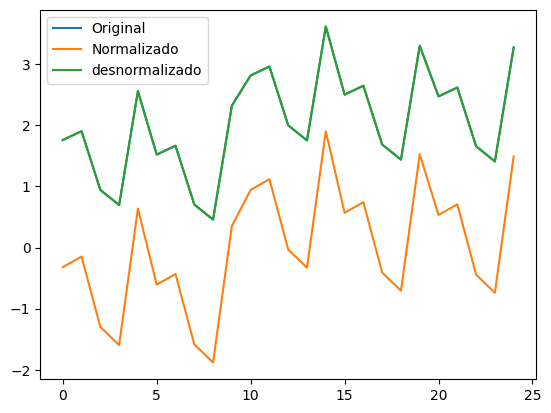

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:37:27.694601: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:37:27.730347: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:37:27.875023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753137448.103235 1779184 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753137448.163724 1779184 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753137448.423273 1779184 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36], [48], [60]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  28
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_2,0.676004,0.528662,0.625569,0.718501,0.216495,0.279807,0.318919,0.266152,0.358174,0.465290,0.558814,0.472618,37.060377,74.024961
model_1_1_1,0.654985,0.509496,0.607014,0.699394,0.230540,0.291184,0.334722,0.284217,0.370683,0.480146,0.530192,0.487707,36.934663,73.899246
model_1_1_0,0.647521,0.502662,0.600420,0.691970,0.235528,0.295241,0.340339,0.291236,0.375527,0.485312,0.520028,0.492955,36.891855,73.856438


DataFrame salvo em ./content/results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.736018,0.581129,0.678186,0.716084,0.176393,0.248660,0.274102,0.091003,0.323749,0.419992,0.640536,0.426606,37.470080,74.434663
model_1_2_8,0.731055,0.576775,0.673882,0.711439,0.179710,0.251245,0.277768,0.092492,0.326772,0.423922,0.633777,0.430598,37.432823,74.397406
model_1_2_7,0.726049,0.572428,0.669487,0.706459,0.183055,0.253825,0.281511,0.094088,0.329757,0.427849,0.626961,0.434587,37.395942,74.360526
model_1_2_6,0.720960,0.568004,0.665024,0.701419,0.186455,0.256452,0.285313,0.095704,0.332770,0.431804,0.620031,0.438605,37.359130,74.323714
model_1_2_5,0.715740,0.563458,0.660444,0.696197,0.189943,0.259150,0.289213,0.097378,0.335819,0.435824,0.612923,0.442688,37.322063,74.286646
model_1_2_4,0.710443,0.558828,0.655812,0.690997,0.193483,0.261899,0.293159,0.099044,0.338903,0.439867,0.605709,0.446794,37.285131,74.249715
model_1_2_3,0.704991,0.554062,0.651030,0.685511,0.197126,0.264728,0.297232,0.100803,0.342018,0.443989,0.598285,0.450981,37.247824,74.212407
model_1_2_2,0.699523,0.549293,0.646228,0.680155,0.200780,0.267559,0.301322,0.102520,0.345167,0.448084,0.590840,0.455141,37.211095,74.175679
model_1_2_1,0.693844,0.544332,0.641228,0.674363,0.204574,0.270504,0.305580,0.104376,0.348344,0.452299,0.583107,0.459422,37.173649,74.138233
model_1_2_0,0.688090,0.539310,0.636159,0.668457,0.208419,0.273486,0.309898,0.106269,0.351530,0.456530,0.575271,0.463719,37.136407,74.100991


DataFrame salvo em ./content/results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.792427,0.615595,0.737504,0.820994,0.138701,0.228199,0.223579,0.132210,0.277745,0.372425,0.717348,0.378291,37.950873,74.915457
model_1_3_8,0.789016,0.612863,0.734386,0.817630,0.140980,0.229821,0.226234,0.134695,0.280220,0.375473,0.712703,0.381386,37.918274,74.882858
model_1_3_7,0.774486,0.608425,0.716539,0.793068,0.150689,0.232456,0.241435,0.152836,0.296309,0.388187,0.692917,0.394301,37.785073,74.749656
model_1_3_6,0.770438,0.605199,0.712761,0.789044,0.153394,0.234371,0.244653,0.155808,0.298913,0.391656,0.687404,0.397824,37.749488,74.714072
model_1_3_5,0.759422,0.597131,0.702054,0.775879,0.160755,0.239161,0.253773,0.165531,0.308110,0.400943,0.672404,0.407257,37.655746,74.620330
model_1_3_4,0.756750,0.596020,0.698872,0.771375,0.162541,0.239820,0.256483,0.168858,0.310652,0.403163,0.668765,0.409513,37.633655,74.598239
model_1_3_3,0.753374,0.594056,0.695199,0.766815,0.164796,0.240986,0.259612,0.172226,0.313112,0.405951,0.664169,0.412344,37.606096,74.570680
model_1_3_2,0.748912,0.590584,0.690930,0.762236,0.167777,0.243047,0.263247,0.175608,0.315795,0.409606,0.658094,0.416057,37.570235,74.534819
model_1_3_1,0.744621,0.587374,0.686742,0.757573,0.170645,0.244952,0.266815,0.179052,0.318434,0.413092,0.652249,0.419598,37.536337,74.500921
model_1_3_0,0.740377,0.584427,0.682406,0.752768,0.173481,0.246702,0.270508,0.182601,0.320959,0.416511,0.646470,0.423070,37.503374,74.467957


DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.887346,0.697678,0.821182,0.844693,0.075276,0.179471,0.152306,0.061521,0.201260,0.274364,0.846599,0.278685,39.173196,76.137779
model_1_4_8,0.885289,0.695921,0.819432,0.841829,0.076650,0.180515,0.153797,0.062656,0.203068,0.276858,0.843798,0.281218,39.137004,76.101587
model_1_4_7,0.870693,0.681203,0.806145,0.803221,0.086403,0.189252,0.165114,0.077950,0.215340,0.293944,0.823923,0.298573,38.897463,75.862047
model_1_4_6,0.868120,0.678932,0.803922,0.799108,0.088122,0.190600,0.167008,0.079579,0.217601,0.296854,0.820419,0.301529,38.858055,75.822639
model_1_4_5,0.861105,0.673795,0.797630,0.793972,0.092810,0.193650,0.172367,0.081613,0.225665,0.304647,0.810867,0.309445,38.754409,75.718992
model_1_4_3,0.857987,0.671646,0.794885,0.793447,0.094893,0.194925,0.174705,0.081821,0.229896,0.308047,0.806621,0.312899,38.710005,75.674589
model_1_4_4,0.858498,0.671494,0.795406,0.790058,0.094552,0.195016,0.174261,0.083164,0.227752,0.307493,0.807316,0.312336,38.717208,75.681792
model_1_4_2,0.843574,0.660637,0.782194,0.785432,0.104524,0.201460,0.185515,0.084997,0.247079,0.323302,0.786995,0.328393,38.516678,75.481262
model_1_4_1,0.810159,0.630158,0.753080,0.718530,0.126852,0.219554,0.210312,0.111498,0.262646,0.356163,0.741494,0.361772,38.129469,75.094053
model_1_4_0,0.806799,0.627161,0.750246,0.714042,0.129097,0.221334,0.212725,0.113276,0.265215,0.359301,0.736918,0.364960,38.094378,75.058962


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.964509,0.748733,0.901553,0.930210,0.023715,0.149163,0.083851,0.030167,0.095609,0.153997,0.951672,0.156423,41.483280,78.447863
model_1_5_8,0.958538,0.746247,0.894774,0.924729,0.027705,0.150638,0.089625,0.032537,0.104754,0.166448,0.943541,0.169069,41.172289,78.136873
model_1_5_7,0.954944,0.744177,0.890956,0.921435,0.030107,0.151868,0.092877,0.033960,0.109241,0.173513,0.938647,0.176245,41.006017,77.970600
model_1_5_6,0.952865,0.742859,0.888803,0.919525,0.031496,0.152650,0.094711,0.034786,0.111702,0.177471,0.935816,0.180266,40.915786,77.880370
model_1_5_5,0.952322,0.742510,0.888246,0.919033,0.031859,0.152857,0.095186,0.034999,0.112345,0.178490,0.935076,0.181301,40.892887,77.857471
model_1_5_4,0.946067,0.738683,0.881708,0.913428,0.036038,0.155129,0.100754,0.037421,0.120060,0.189837,0.926560,0.192827,40.646361,77.610945
model_1_5_3,0.938962,0.733903,0.874487,0.907103,0.040786,0.157967,0.106904,0.040155,0.127905,0.201954,0.916885,0.205135,40.398852,77.363436
model_1_5_2,0.938136,0.733295,0.873670,0.906370,0.041338,0.158328,0.107600,0.040472,0.128747,0.203317,0.915759,0.206519,40.371952,77.336536
model_1_5_1,0.932966,0.730430,0.868069,0.902398,0.044792,0.160029,0.112371,0.042189,0.134376,0.211642,0.908719,0.214975,40.211432,77.176016
model_1_5_0,0.914868,0.716960,0.849819,0.883842,0.056885,0.168025,0.127916,0.050210,0.166111,0.238507,0.884076,0.242263,39.733432,76.698016


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.974158,0.755522,0.911579,0.966250,0.017268,0.145133,0.075312,0.017631,0.078004,0.131407,0.964811,0.133477,42.117815,79.082399
model_1_6_7,0.972782,0.754286,0.910266,0.967172,0.018187,0.145867,0.076430,0.017149,0.080291,0.134860,0.962937,0.136984,42.014082,78.978666
model_1_6_8,0.972770,0.754186,0.910299,0.966917,0.018195,0.145926,0.076402,0.017282,0.080147,0.134890,0.962920,0.137015,42.013172,78.977756
model_1_6_6,0.971849,0.753332,0.909406,0.967692,0.018811,0.146433,0.077162,0.016877,0.081696,0.137152,0.961667,0.139312,41.946675,78.911259
model_1_6_5,0.970859,0.752531,0.908447,0.967794,0.019472,0.146908,0.077980,0.016824,0.083125,0.139544,0.960318,0.141741,41.877515,78.842098
model_1_6_4,0.969441,0.751399,0.907050,0.967917,0.020419,0.147580,0.079169,0.016760,0.085508,0.142896,0.958388,0.145147,41.782547,78.747130
model_1_6_1,0.967264,0.750613,0.904473,0.968179,0.021874,0.148047,0.081364,0.016623,0.090293,0.147899,0.955424,0.150228,41.644899,78.609482
model_1_6_3,0.968164,0.750539,0.905727,0.967841,0.021273,0.148091,0.080296,0.016800,0.087814,0.145853,0.956648,0.148150,41.700613,78.665197
model_1_6_0,0.967011,0.750405,0.904230,0.968097,0.022043,0.148170,0.081571,0.016666,0.090640,0.148469,0.955079,0.150807,41.629514,78.594098
model_1_6_2,0.967658,0.750055,0.905262,0.967760,0.021611,0.148378,0.080693,0.016842,0.088524,0.147006,0.955960,0.149321,41.669133,78.633717


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
